[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mariyamuneeb/ssl_wordspotting/blob/main/VariationalAE.ipynb)

## Project Setup

In [1]:
import os
!git clone https://github.com/mariyamuneeb/ssl_wordspotting
os.chdir('/content/ssl_wordspotting')
!pip install -qqq wandb

from setup_wandb import wandb_login
wandb_login()

Cloning into 'ssl_wordspotting'...
remote: Enumerating objects: 163, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 163 (delta 82), reused 104 (delta 38), pack-reused 0
Receiving objects: 100% (163/163), 6.73 MiB | 28.61 MiB/s, done.
Resolving deltas: 100% (82/82), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 KB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 5.9 MB/s eta 0:00:00
/content/ssl_wordspotting
Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [9]:
import torch

In [10]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import wandb
import numpy as np
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Standard Datasets

## Initialization

In [ ]:
num_channels = 3
base_channel_size=32
lr = 10e-2
latent_dim = 384
epochs = 300
plot_freq = 10

wandb.init(
      # Set the project where this run will be logged
      project="SSL", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"VAE", 
      # Track hyperparameters and run metadata
      config={
      "architecture": "CNN",
      "dataset": "CIFAR-10",
      "epochs": epochs,
      "latent_dim":latent_dim
      })

In [ ]:
torch.manual_seed(0)

# d = 4

vae = VariationalAutoencoder(latent_dims=4)

optim = torch.optim.Adam(vae.parameters(), lr=lr)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

## Import/Load Datasets

In [ ]:
data_dir = 'dataset'
# train_dataset = torchvision.datasets.MNIST(data_dir, train = True, download = True)
# test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_dataset = torchvision.datasets.CIFAR10(data_dir,train=True,download=True)
test_dataset  = torchvision.datasets.CIFAR10(data_dir,train=False, download=True)

In [ ]:
img = train_dataset[1][0]
label = train_dataset[1][1]
print(img.mode)
print(label)
plt.imshow(img)
plt.show()

In [ ]:
img.size

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor(), ])

test_transform = transforms.Compose([transforms.ToTensor(), ])

In [ ]:
train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

VariationalAutoencoder class, which combines the Encoder and Decoder classes 
The encoder and decoder networks contain **three convolutional layers** and **two fully connected layers**. 
Some batch normal layers are added to have more robust features in the latent space. 
Differently from the standard autoencoder, the **encoder returns mean and variance matrices** and we use them to obtain the sampled latent vector. 

## Training Loop

In [ ]:
for epoch in range(epochs):
   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, epochs,train_loss,val_loss))
   if epoch%plot_freq==0:
       plot_ae_outputs(vae.encoder,vae.decoder,n=10)

In [ ]:
break

In [ ]:
train_loader

# VAE on Hand-written Dataset 

## Dataset

### Connect to GDrive

In [24]:
from google.colab import drive
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/Datasets/tif'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Imports

In [25]:
import os
import cv2
import math
from PIL import Image
import matplotlib.pyplot as plt
from statistics import mean
from math import floor

### Custom Dataset Definition

In [26]:
images_paths = [os.path.join(PATH,i) for i in os.listdir(PATH)]
split = 0.85
train_idx = math.floor(split*len(images_paths))
train_images = images_paths[:train_idx]
test_images = images_paths[train_idx:]

### Plotting Few Images

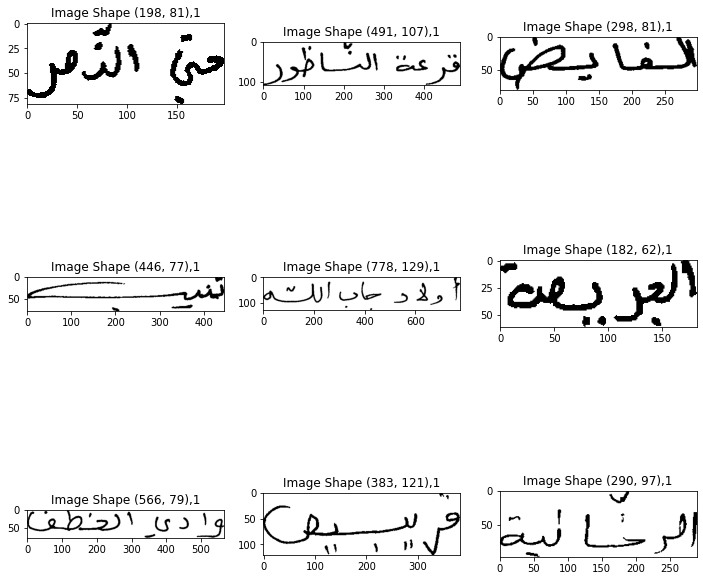

In [27]:
random_imgs = random.sample(train_images, 9)
random_imgs = [Image.open(i) for i in random_imgs]
_, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(random_imgs, axs):
    ax.imshow(img)
    ax.title.set_text(f'Image Shape {img.size},{img.mode}')
plt.show()

### Finding Ave Image Dimensions

In [28]:
h_list = list()
w_list = list()

for p in train_images:
    h_list.append(Image.open(p).size[1])
    w_list.append(Image.open(p).size[0])
num_channels = int(Image.open(p).mode)

h_ave = floor(mean(h_list))
w_ave = floor(mean(w_list))
# resize_size = (h_ave,w_ave)
resize_size = (128,128)

### Dataset Definitions

In [29]:
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize(resize_size),])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize(resize_size),])

hw_train_dataset = MyDataset(img_paths=train_images,transform=train_transform)
hw_test_dataset = MyDataset(img_paths=test_images,transform=test_transform)

NameError: ignored

### Dataloader and Batching Definitions

In [ ]:
m=len(hw_train_dataset)


batch_size=8

train_loader = torch.utils.data.DataLoader(hw_train_dataset, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(hw_test_dataset, batch_size=batch_size)

## Plotting

## Initialization

### Hyperparameters

In [ ]:
base_channel_size = 32
lr = 1e-3
latent_dim = 512
epochs = 300
plot_freq = 10

In [ ]:
hw_train_dataset[0][0].shape

### W&B Init

In [ ]:
wandb.init(
      # Set the project where this run will be logged
      project="SSL", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"VAE", 
      # Track hyperparameters and run metadata
      config={
      "architecture": "CNN",
      "dataset": "Hand Written Dataset",
      "lr":lr,
      "epochs": epochs,
      "latent_dim":latent_dim
      })

### Initialize VAE

Initialize the VariationalAutoencoder class, the optimizer, and the device to use the GPU in the code.

In [ ]:
torch.manual_seed(0)

vae = VariationalAutoencoder(num_channels,base_channel_size,latent_dim)
print(vae)

optim = torch.optim.Adam(vae.parameters(), lr=lr)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')
vae.to(device)

## Training

### Train Loop

In [ ]:
for epoch in range(epochs):
   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, epochs,train_loss,val_loss))
   if epoch%plot_freq==0:
       plot_ae_custom_ds_outputs(vae.encoder,vae.decoder,hw_test_dataset,n=10)

# IAM Dataset


## Dataset

In [2]:
from models.dataset_utils import IAMDataset2,IAMDataset
from models.layers import VariationalEncoder,Decoder
from experiment_utils.utils import train_epoch,test_epoch
from PIL import Image
from math import floor
from statistics import mean

### Copy Dataset to Colab Instance

In [3]:
from data_utils.utils import copy_iam_dataset_to_colab
copy_iam_dataset_to_colab()

Copying IAM Dataset from GDrive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
IAM Dataset Zip now copied


In [4]:
train_dir = '/content/ssl_wordspotting/data/words_training'
test_dir = '/content/ssl_wordspotting/data/words_test'

In [11]:
resize_size = (128,128)
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize(resize_size),])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize(resize_size),])
iam_train_dataset = IAMDataset(train_dir,transform=train_transform)
iam_test_dataset = IAMDataset(test_dir,transform=train_transform)

### Plot Few Samples

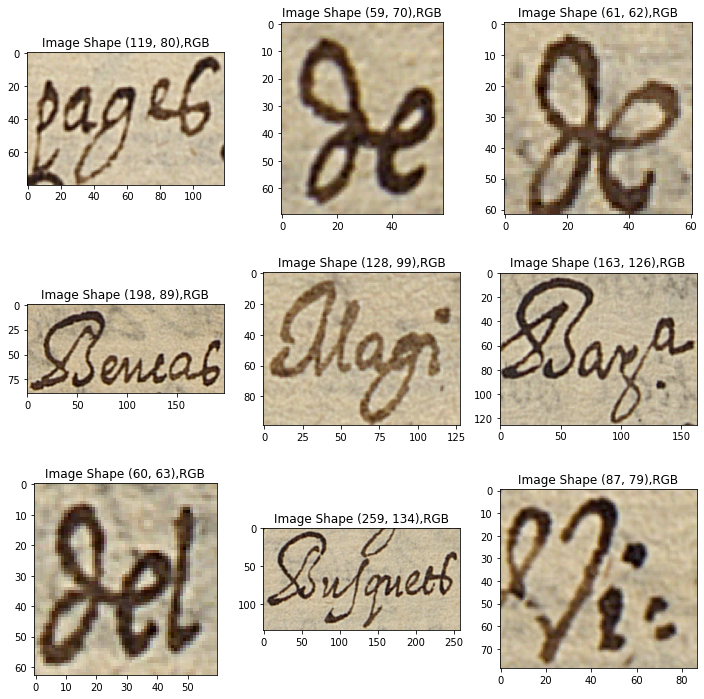

In [12]:
from data_utils.plotting import plot_samples,plot_reconstructions
plot_samples(iam_train_dataset,9)

In [13]:
batch_size=256

train_loader = torch.utils.data.DataLoader(iam_train_dataset, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(iam_test_dataset, batch_size=batch_size)

## Initialization

### HyperParameters

In [20]:
base_channel_size = 32
num_channels = 3
lr = 1e-3
latent_dim = 512
epochs = 150
plot_freq = 10

### W&B Init

In [21]:
wandb.init(
      # Set the project where this run will be logged
      project="SSL", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"IAM VAE", 
      # Track hyperparameters and run metadata
      config={
      "architecture": "CNN",
      "dataset": "IAM Hand Written Dataset",
      "lr":lr,
      "epochs": epochs,
      "latent_dim":latent_dim
      })

wandb: Currently logged in as: mariyamuneeb. Use `wandb login --relogin` to force relogin


### Define VAE

In [22]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, num_channels, base_channel_size, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(num_channels, base_channel_size, latent_dim)
        self.decoder = Decoder(num_channels, base_channel_size, latent_dim)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

### Initialize VAE

In [31]:
torch.manual_seed(0)

vae = VariationalAutoencoder(num_channels,base_channel_size,latent_dim)

vae.to(device)
optim = torch.optim.Adam(vae.parameters(), lr=lr)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')


Selected device: cuda


## Training

### Train Loop

In [34]:
for epoch in range(epochs):
   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, epochs,train_loss,val_loss))
   if epoch%plot_freq==0:
       plot_reconstructions(vae.encoder,vae.decoder,iam_test_dataset,device, n=10)
       

RuntimeError: ignored

In [ ]:
device

## Initialization

### HyperParameters

In [ ]:
base_channel_size = 32
num_channels = 3
lr = 1e-3
latent_dim = 512
epochs = 150
plot_freq = 10

### W&B Init

In [ ]:
wandb.init(
      # Set the project where this run will be logged
      project="SSL", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"IAM VAE", 
      # Track hyperparameters and run metadata
      config={
      "architecture": "CNN",
      "dataset": "IAM Hand Written Dataset",
      "lr":lr,
      "epochs": epochs,
      "latent_dim":latent_dim
      })

### Define VAE

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, num_channels, base_channel_size, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(num_channels, base_channel_size, latent_dim)
        self.decoder = Decoder(num_channels, base_channel_size, latent_dim)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

### Initialize VAE

In [ ]:
torch.manual_seed(0)

vae = VariationalAutoencoder(num_channels,base_channel_size,latent_dim)

vae.to(device)
optim = torch.optim.Adam(vae.parameters(), lr=lr)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')


## Training

### Train Loop

In [ ]:
for epoch in range(epochs):
    train_loss = train_epoch(vae,device,train_loader,optim)
    val_loss = test_epoch(vae,device,valid_loader)
    
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, epochs,train_loss,val_loss))
    if epoch%plot_freq==0:
        plot_reconstructions(vae.encoder,vae.decoder,iam_test_dataset,device,'IAM HW', n=10)
        ## save model here
        ## run evaluation of MAP

In [ ]:
PATH = '/content/drive/MyDrive/Mariyah_Phd/weights/vae_weights.pt'
torch.save(model, PATH)

In [4]:
!pwd

/content/ssl_wordspotting
